# Analyze red noise in one pulsar

A free spectral model is used to describe the distribution of Fourier coefficients. The distribution on the free powers is then learned with a normalizing flow, which is reparameterized as a power law. Another flow learns this "second-stage" likelihood to recover the distribution on the power law parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jax import config, jit, vmap
import jax.numpy as jnp
import jax.random as jr

import numpyro
import numpyro.distributions as dist

# use double precision
config.update('jax_enable_x64', True)

import sys
import os
sys.path.append(os.path.abspath('..'))

from PTA import PTA
from likelihood import get_likelihood_obj
from samples import Samples
import constants as const

import torch
import zuko
import random

import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

import dill

%load_ext autoreload
%autoreload 2

## Simulate data

In [2]:
# make PTA detector and model
pta = PTA(Np=1,  # number of pulsars
          Tspan_yr=15.,  # observation time span
          Nf=30,  # number of frequency bins to inject / model
          model_wn=False,  # model white noise (EFAC)
          model_rn=False,  # model intrinsic pulsar red noise
          model_gwb=True,  # model gravitational wave background
          model_cw=False,  # model continuous wave
          gwb_free_spectral=True,  # free spectral model
          efacs_inj=jnp.array([1.0]),  # injected EFAC value
          gwb_power_law_inj=jnp.array([-13.4, 3.2]),  # injected power law parameters
          seed=0,  # random seed for simulation
          )

# likelihood object
l = get_likelihood_obj(pta)

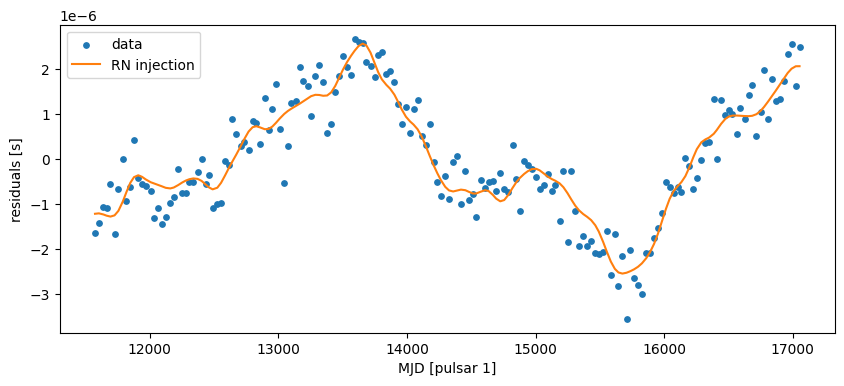

In [3]:
# plot data and injected signals
psr_ndx = 0
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.residuals[psr_ndx], color='C0', s=15, label='data')
rn_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], rn_residuals_inj, color='C1', label='RN injection')
plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.show()

In [4]:
# posterior function
@jit
def lnpost(x):

    # unpack parameters
    log10_rhos = x[pta.gwb_ndxs]
    a = x[pta.a_ndxs]

    # covariance of Fourier coefficients
    phi = jnp.repeat(10. ** log10_rhos, 2)

    # prior on Fourier coefficients
    lnprior_val = -0.5 * jnp.sum(a**2. / phi) - 0.5 * jnp.sum(jnp.log(phi))

    # likelihood
    lnlike_val = l.lnlike(pta.efacs_inj, a)

    return lnprior_val + lnlike_val

vectorized_lnpost = jit(vmap(lnpost))

## Sample posterior with NumPyro for free spectral

In [5]:
# kernel
def sampling_model():
    # uniform prior on hyper-parameters
    rn_hypers = numpyro.sample('rn_hypers', dist.Uniform(pta.gwb_mins, pta.gwb_maxs))

    # normal prior on Fourier coefficients
    a_standard = numpyro.sample('a_standard', dist.Normal().expand([pta.Na]))
    a_transformed = jnp.repeat(jnp.sqrt(10. ** rn_hypers), 2) * a_standard
    a = numpyro.deterministic('a', a_transformed)

    # likelihood
    numpyro.factor('ln_likelihood', l.lnlike(pta.efacs_inj, a))

In [6]:
# sample with NumPyro NUTS
nuts_kernel = numpyro.infer.NUTS(sampling_model,
                                 dense_mass=True)
mcmc = numpyro.infer.MCMC(sampler=nuts_kernel,
                          num_warmup=int(1e4),
                          num_samples=int(2e6))
mcmc.run(jr.key(4))
samples_dict = mcmc.get_samples()

sample: 100%|██████████| 2010000/2010000 [38:09<00:00, 878.03it/s, 127 steps of size 3.83e-02. acc. prob=0.89] 


In [7]:
# rewrite Fourier coefficient labels for one pulsar
a_labels_one_psr = np.array([rf'$a^R_{{{j // 2}}}$' if j % 2 == 0 else \
                             rf'$b^R_{{{j // 2}}}$'
                             for j in range(2, pta.Na + 2)])

# rewrite hyper-parameter labels for one pulsar
rho_labels = np.array([rf'$\log_{{{10}}}\rho^R_{{{i}}}$'
                       for i in np.arange(1, pta.Nf + 1)])

# convert samples dictionary into numpy array
samples_arr = np.concatenate((samples_dict['rn_hypers'],
                              samples_dict['a'],
                              ), axis=1)

# make samples object for post-processing
samples = Samples(samples_arr=jnp.concatenate((samples_arr[:int(3.5e6)],
                                               samples_arr[int(3.75e6):])),
                  labels=np.concatenate((rho_labels, a_labels_one_psr)),
                  x_inj=pta.x_inj,
                  lnpost_func=lnpost,
                  jax=True)

## Post-processing

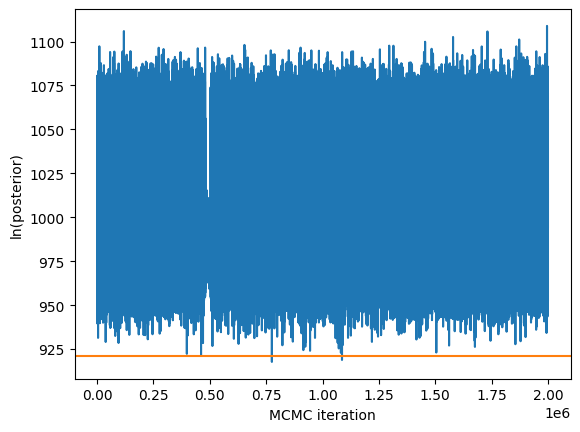

In [8]:
samples.plt_posterior_vals()

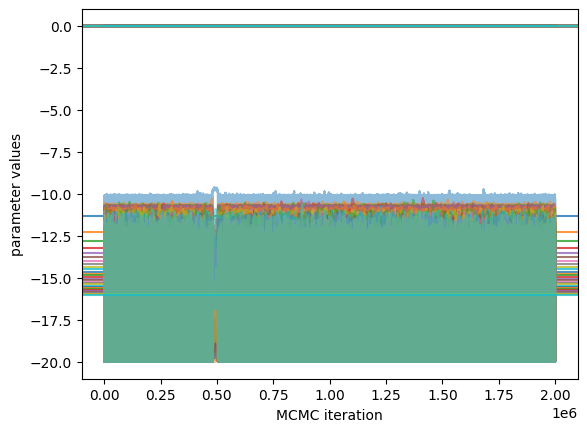

In [9]:
# plot parameter values over MCMC samples
samples.trace_plt(legend=False)

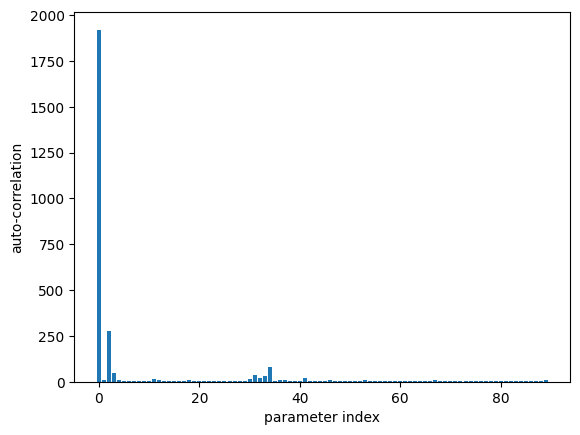

In [10]:
# plot auto-correlation length of parameters
samples.plt_auto_corr()

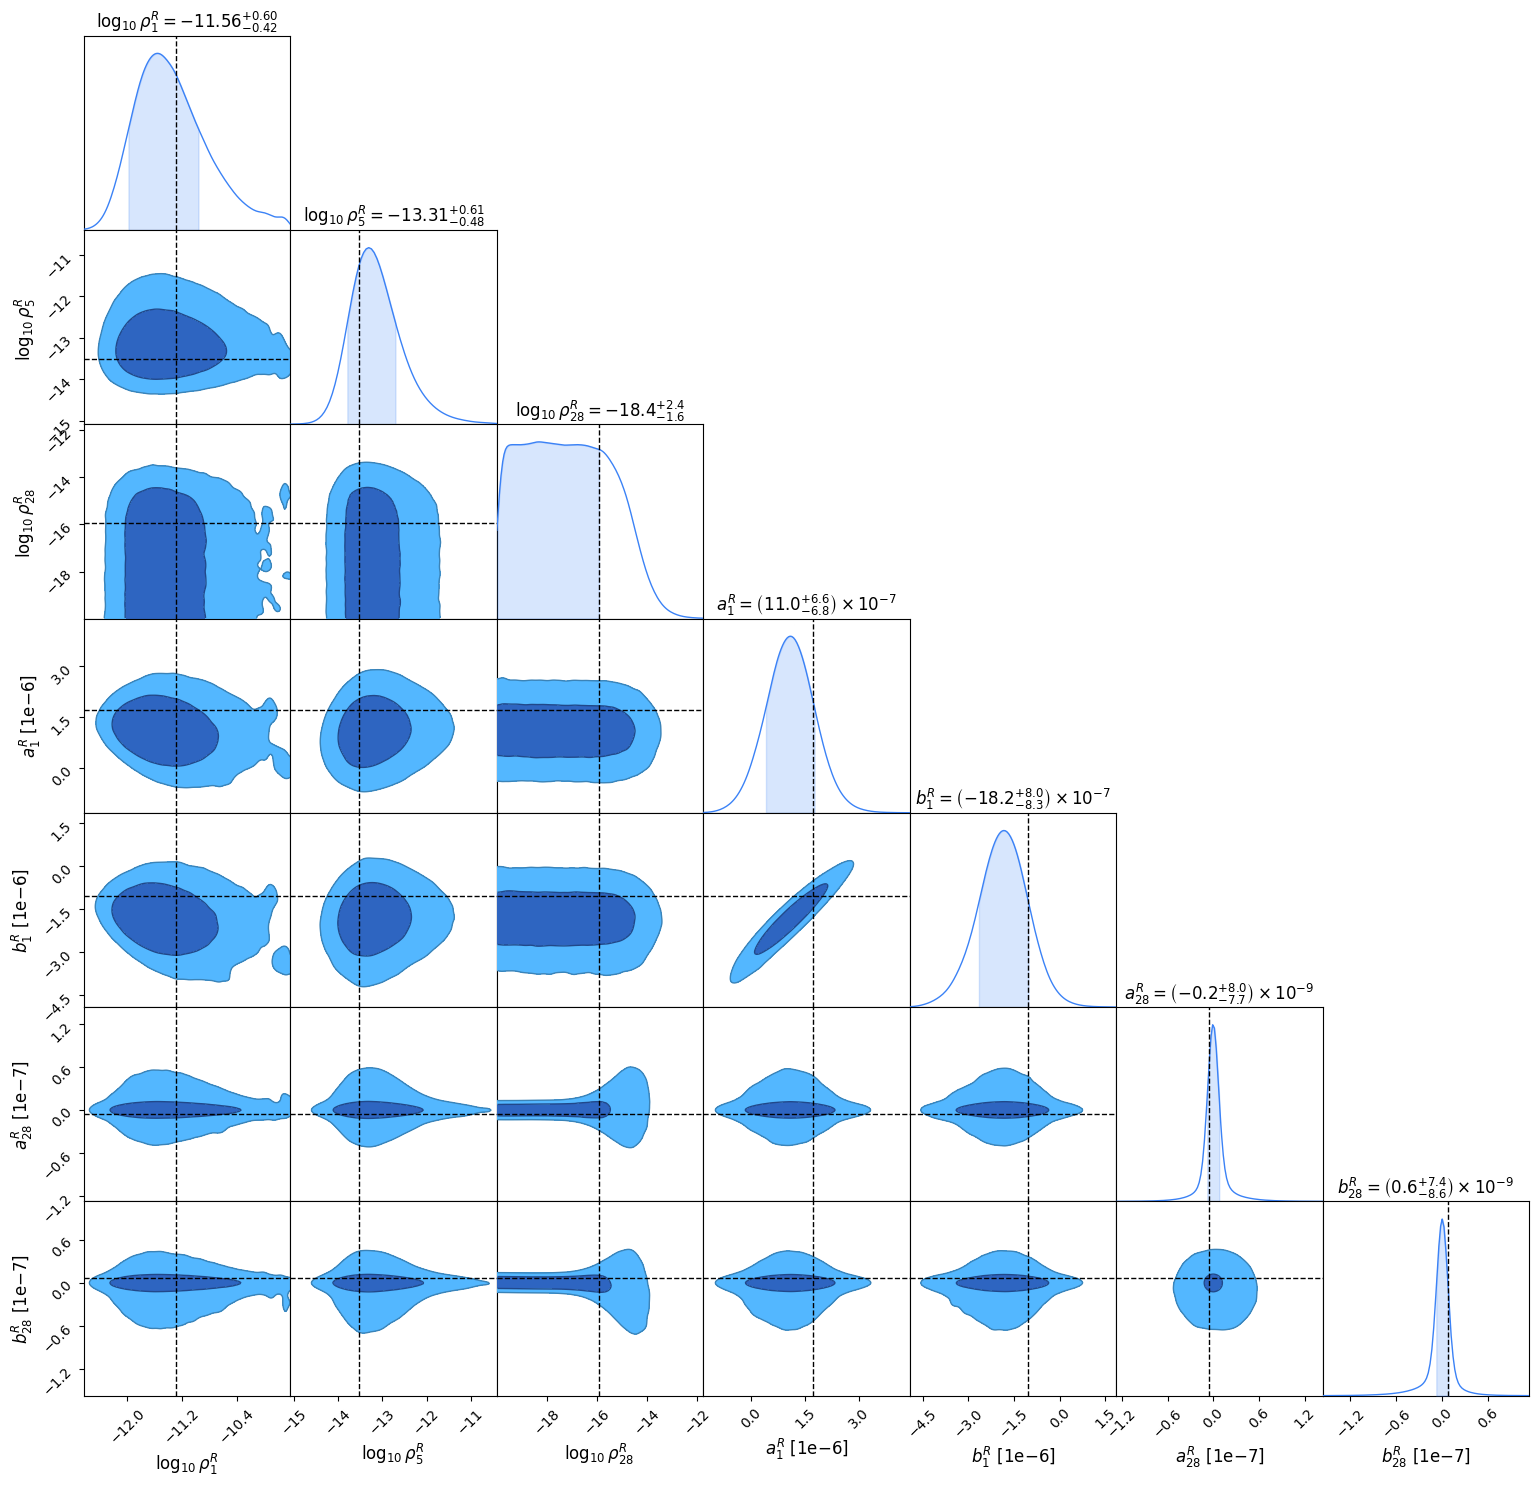

In [11]:
# indices of parameters to plot
ndxs = np.concatenate((pta.gwb_ndxs[0:1],
                       pta.gwb_ndxs[4:5],
                       pta.gwb_ndxs[-3:-2],
                       pta.a_ndxs[:2],
                       pta.a_ndxs[-6:-4]))
# corner plot
samples.corner_plt(param_ndxs=ndxs, color='blue', thin=2)

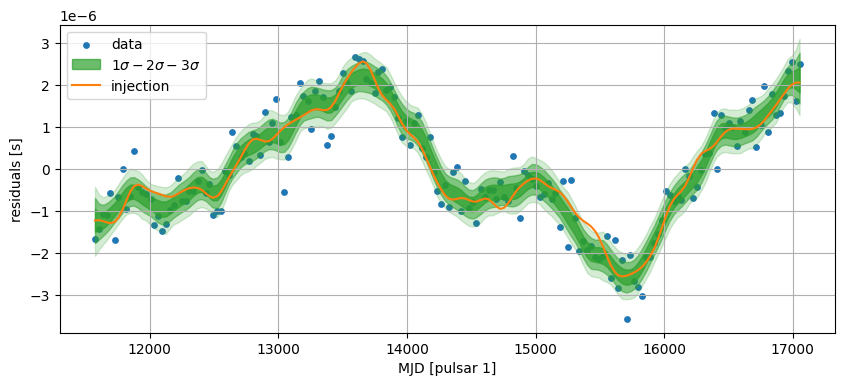

In [12]:
# Bayesogram
psr_ndx = 0
fair_draw_ndxs = np.random.choice(samples_arr.shape[0], (10_000,))

# percentile layers for plotting densities of samples
percentile_layers = [0.15, 2.5, 16.]
alphas = [0.2, 0.5, 0.7]

# plot data, samples, and injected signals
plt.figure(figsize=(10, 4))
plt.scatter(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ pta.residuals[psr_ndx], color='C0', s=15, label='data')

rn_gwb_signals = np.array([pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ samples_arr[ndx, pta.a_ndxs].reshape((pta.Np, pta.Na))[psr_ndx]
                           for ndx in fair_draw_ndxs])
for percentile, alpha in zip(percentile_layers, alphas):
    if percentile != percentile_layers[-1]:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha)
    else:
        plt.fill_between(pta.MJDs[psr_ndx], np.percentile(rn_gwb_signals, percentile, axis=0),
                        np.percentile(rn_gwb_signals, 100. - percentile, axis=0),
                        color='C2', alpha=alpha, label=r'$1\sigma-2\sigma-3\sigma$')
rn_gwb_residuals_inj = pta.Rs[psr_ndx] @ pta.Fs[psr_ndx] @ pta.a_inj.reshape((pta.Np, pta.Na))[psr_ndx]
plt.plot(pta.MJDs[psr_ndx], pta.Rs[psr_ndx] @ rn_gwb_residuals_inj, color='C1', label='injection')

plt.xlabel(f'MJD [pulsar {psr_ndx + 1}]')
plt.ylabel('residuals [s]')
plt.legend()
plt.grid()
plt.show()

## Learn free spectral distribution with normalizing flow

In [13]:
# only learn distribution on free power (not Fourier coefficients)
free_spectral_samples = torch.tensor(samples.samples[::10, pta.gwb_ndxs])

In [14]:
# functions to "normalized" and "unnormalize" samples
# normalized samples have are centered on zero and have symmetric bounds
B = 4
max_val = torch.max(free_spectral_samples, axis=0).values
min_val = torch.min(free_spectral_samples, axis=0).values
h = (max_val - min_val) / 2
mean_val = (max_val + min_val) / 2

def normalize(sample):
    return B * (sample - mean_val) / h

def unnormalize(sample):
    return sample * h / B + mean_val

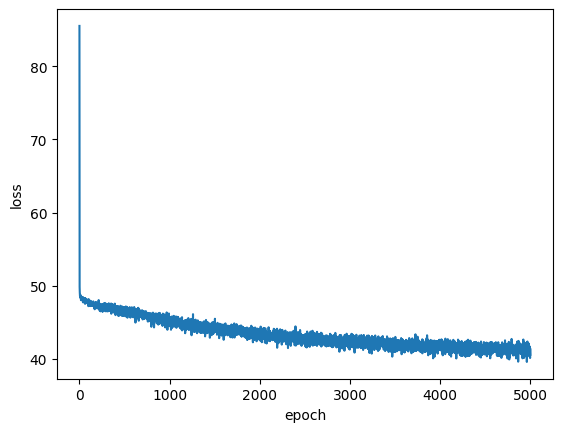

In [15]:
# train normalzing flow
torch.set_default_dtype(torch.float64)

# define flow
free_spectral_flow = zuko.flows.spline.NSF(features=pta.Nf,
                                           context=0,
                                           bins=8,
                                           passes=2,
                                           hidden_features=[512] * 4)

# data is normalized free spectral samples
normalized_samples = normalize(free_spectral_samples).to(torch.float64)

# attributes for training
batch_size = 512
optimizer = torch.optim.Adam(free_spectral_flow.parameters(), lr=1e-3)
losses = []
num_epoch = int(5e4)

# train flow
for epoch in range(num_epoch):

    # randomly draw from data to train
    idx = random.sample(range(normalized_samples.shape[0]), k=batch_size)
    fair_draws = normalized_samples[idx]

    # compute loss function
    loss = -free_spectral_flow().log_prob(fair_draws).mean()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    # update progress and print loss function
    if epoch % 10 == 0:
        print(f'{np.round(epoch / num_epoch * 100, 3)}%  loss = {loss.item()}', end='\r')
        losses.append(loss.item())
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [16]:
# sample from flow and unnormalize samples
flow_samples = unnormalize(free_spectral_flow().sample((int(1e5),)))

Parameter $\log_{10}\rho^R_{6}$ in chain HMC is not constrained
Parameter $\log_{10}\rho^R_{6}$ in chain normalizing flow is not constrained
Parameter $\log_{10}\rho^R_{8}$ in chain HMC is not constrained
Parameter $\log_{10}\rho^R_{9}$ in chain HMC is not constrained
Parameter $\log_{10}\rho^R_{9}$ in chain normalizing flow is not constrained
Parameter $\log_{10}\rho^R_{10}$ in chain HMC is not constrained
Parameter $\log_{10}\rho^R_{10}$ in chain normalizing flow is not constrained


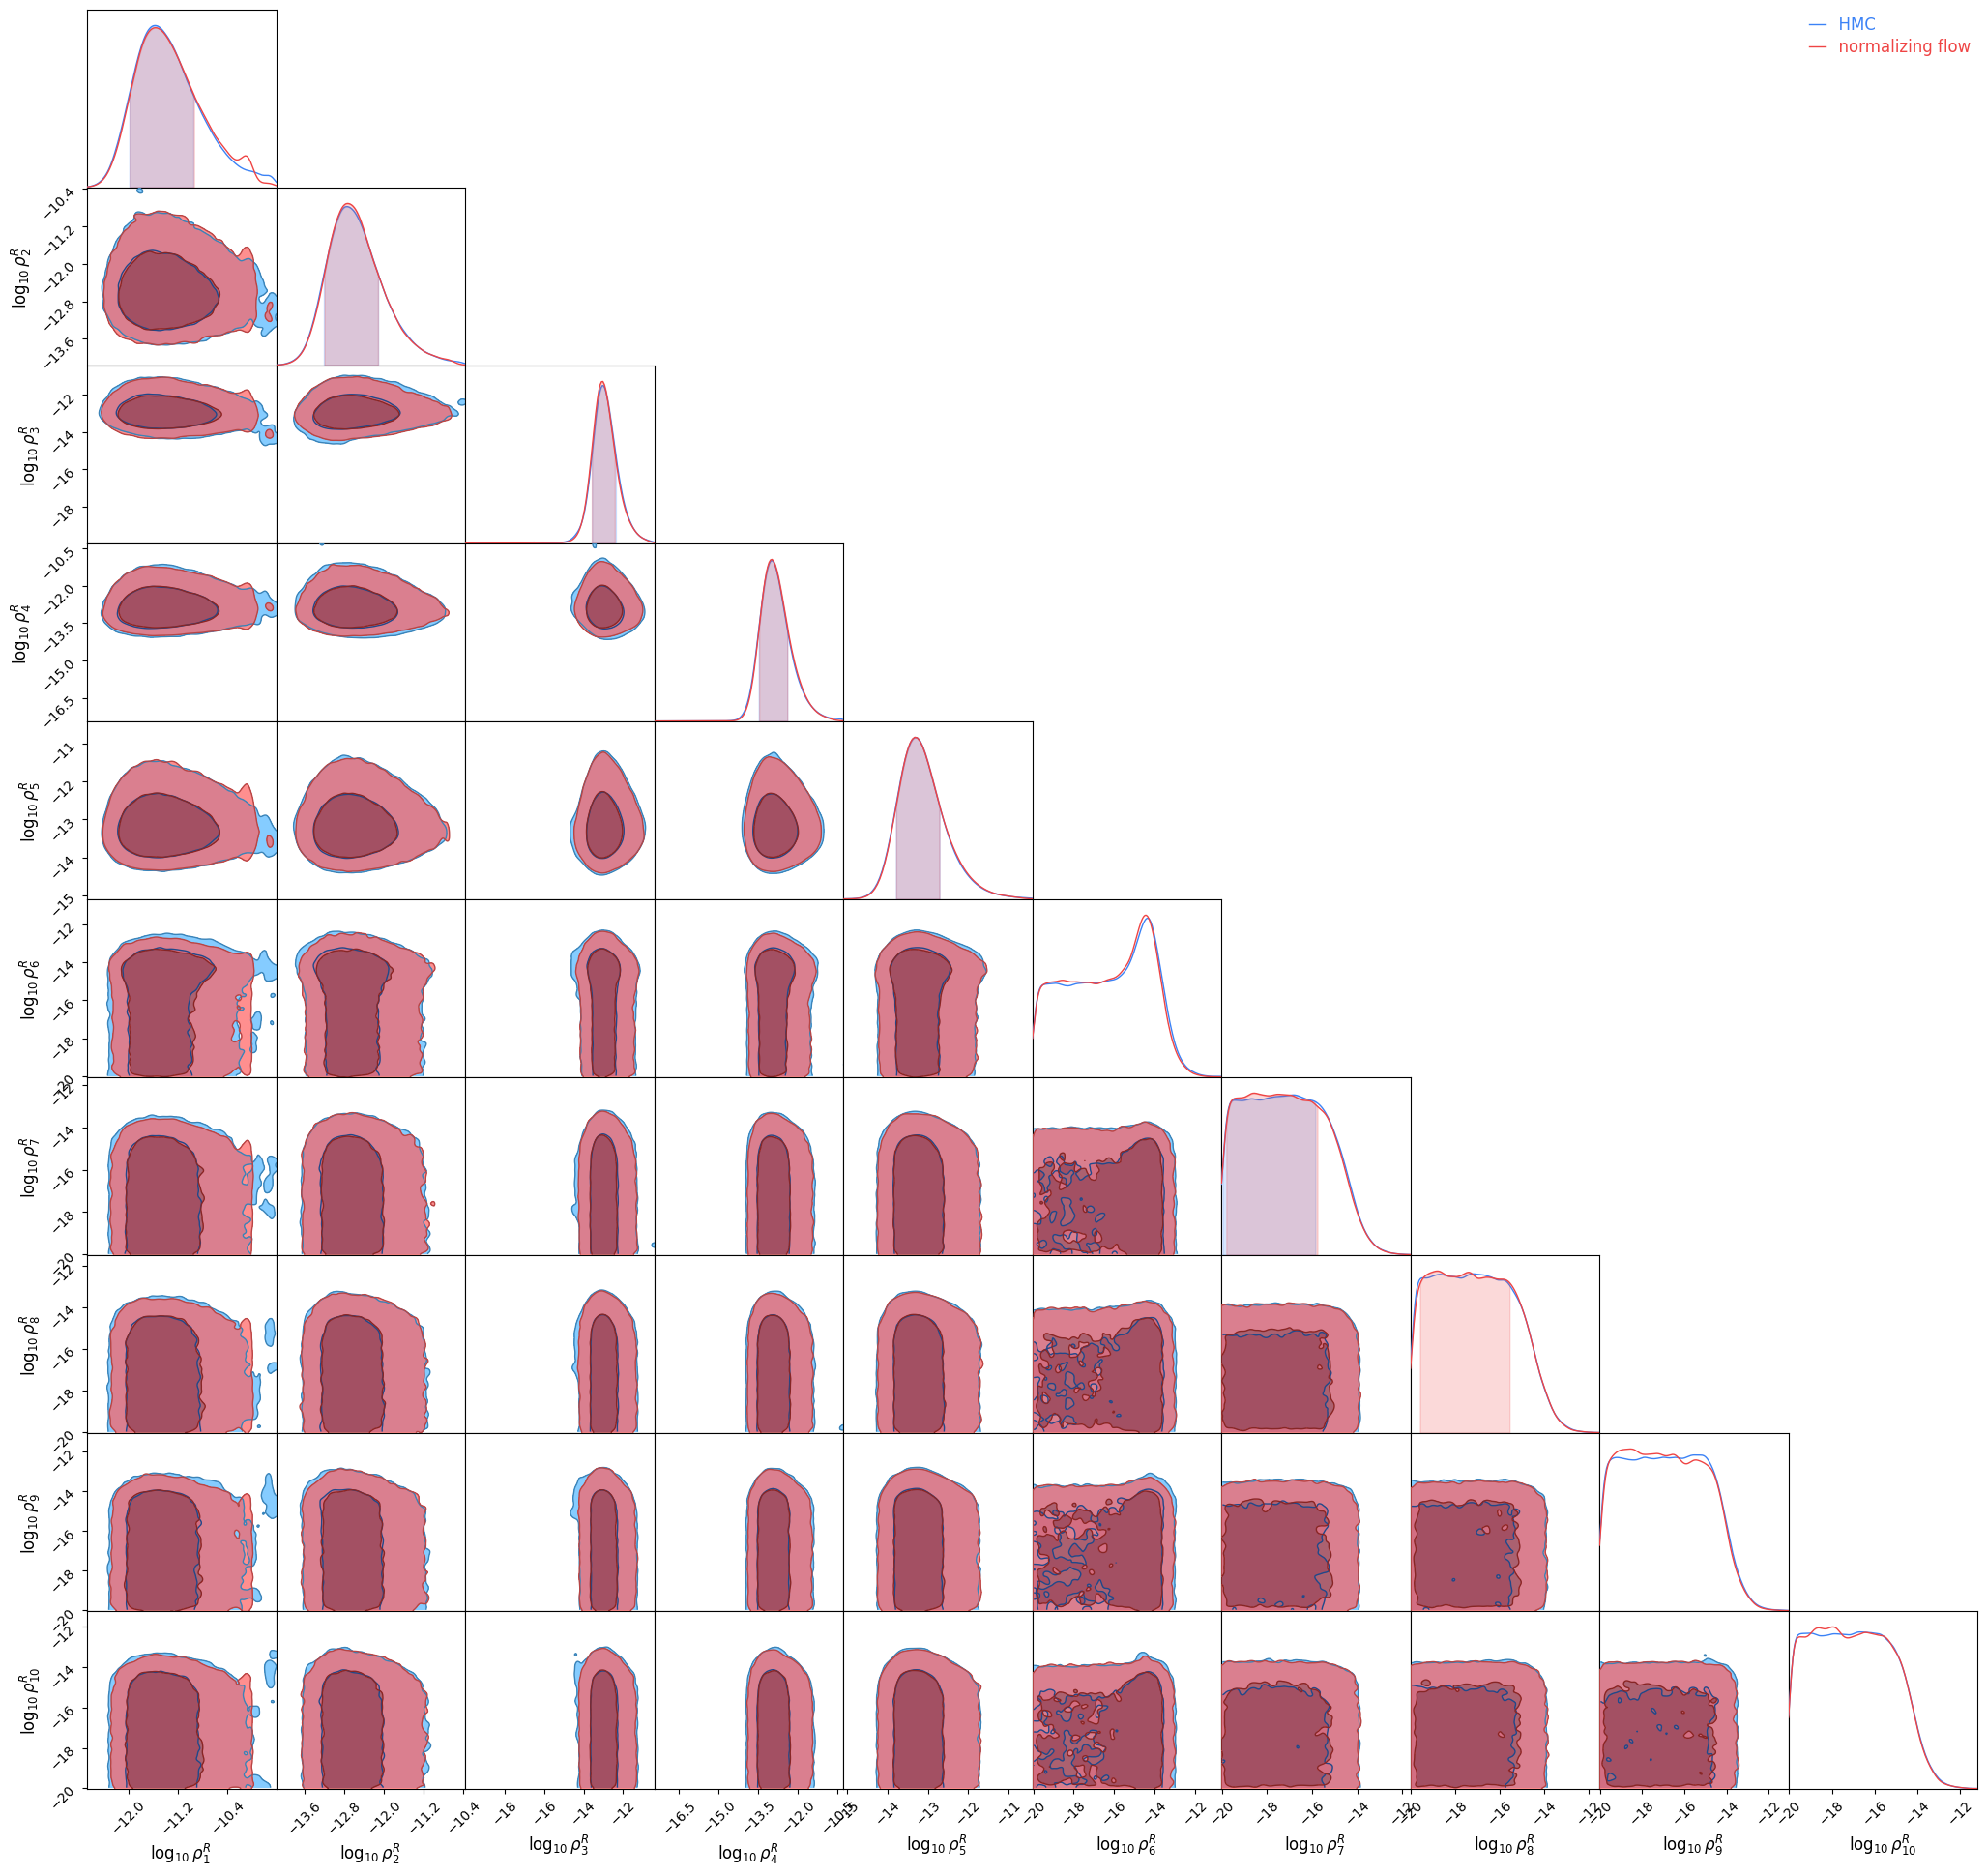

In [17]:
# plot original and flow samples
ndxs = np.r_[:10]
df_hmc = pd.DataFrame(free_spectral_samples, columns=samples.labels[pta.gwb_ndxs])
df_flow = pd.DataFrame(flow_samples, columns=samples.labels[pta.gwb_ndxs])
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc.iloc[:, ndxs], name='HMC'))
c.add_chain(Chain(samples=df_flow.iloc[:, ndxs], name='normalizing flow', color='red'))
c.add_truth(Truth(location={name: val for name, val in zip(pta.x_labels, pta.x_inj)}))
fig = c.plotter.plot()

## Second stage modeling

The learned density from the normalizing flow above is reparameterized with a power law. The subsequent density is learned with another normalizing flow.

In [18]:
# power law covariance in torch
rho_scale = ((const.year_sec ** 3.) / (12. * (jnp.pi ** 2.) * pta.Tspan))
rho_scale1 = pta.Tspan / const.year_sec
arr = jnp.repeat(jnp.arange(1, pta.Nf + 1), 2)
arr /= rho_scale1
arr = torch.tensor(arr)

# diagonal of covariance matrix
def get_rho_diag_torch(hyper_params):
    logAmp, gamma = hyper_params
    Amp = 10. ** logAmp
    return (Amp ** 2.) * rho_scale * (arr **  (-gamma))

# vectorized covariance for multiple inputs
def vec_get_rho_diag_torch(hyper_params):
    logAmp, gamma = hyper_params.T  # shape (N,)
    Amp = 10. ** logAmp
    return (Amp[:, None] ** 2) * rho_scale * (arr[None, :] ** (-gamma[:, None]))

In [19]:
# define flow once outside of likelihood
flow_fs = free_spectral_flow()

# second stage likelihood (reparameterize with power law)
def second_stage_lnlike(x):
    log10rhos = torch.log10(get_rho_diag_torch(x)[::2])
    lnlike = flow_fs.log_prob(normalize(log10rhos))
    return lnlike

# vectorize likelihood for multiple inputs
def vec_second_stage_lnlike(x):
    log10rhos = torch.log10(vec_get_rho_diag_torch(x)[:, ::2])
    lnlike = flow_fs.log_prob(normalize(log10rhos))
    return lnlike

In [20]:
%timeit second_stage_lnlike(torch.tensor([-14, 3]))

5.27 ms ± 175 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


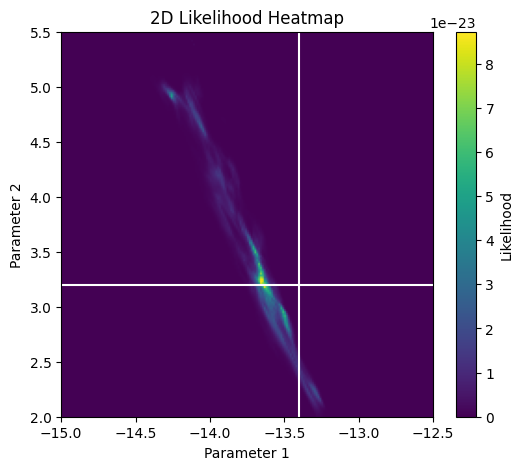

In [21]:
def plot_likelihood_heatmap(likelihood_fn, bounds, n=100, m=100):
    """
    Plot a 2D likelihood heatmap.

    Parameters
    ----------
    likelihood_fn : callable
        Function that accepts a tensor of shape (N, 2) and returns (N,) likelihood values.
    bounds : tuple
        ((x_min, x_max), (y_min, y_max)) bounds for the two parameters.
    n, m : int
        Number of grid points along x and y.
    """
    (x_min, x_max), (y_min, y_max) = bounds

    # Create grid
    x = torch.linspace(x_min, x_max, n)
    y = torch.linspace(y_min, y_max, m)
    X, Y = torch.meshgrid(x, y, indexing="xy")

    # Flatten grid for likelihood evaluation
    points = torch.stack([X.flatten(), Y.flatten()], dim=1)

    # Evaluate likelihood
    Z = likelihood_fn(points)  # shape (n*m,)
    Z = torch.exp(Z.reshape(n, m))

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    im = plt.imshow(Z.detach().numpy(), origin='lower',
                    extent=(x_min, x_max, y_min, y_max),
                    aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Likelihood')
    plt.axvline(pta.gwb_power_law_inj[0], color='white')
    plt.axhline(pta.gwb_power_law_inj[1], color='white')
    plt.xlabel('Parameter 1')
    plt.ylabel('Parameter 2')
    plt.title('2D Likelihood Heatmap')
    plt.show()
    return X.detach().numpy(), Y.detach().numpy(), Z.detach().numpy()

X, Y, Z = plot_likelihood_heatmap(vec_second_stage_lnlike, ((-15, -12.5), (2, 5.5)), 200, 200)

In [22]:
def sample_from_likelihood_grid(X, Y, Z, num_samples=1000, log_likelihood=False):
    """
    Draw samples from a 2D likelihood grid.

    Parameters
    ----------
    X, Y : 2D arrays
        Meshgrid arrays of parameter values (same shape as Z).
    Z : 2D array
        Likelihood values (can be unnormalized).
    num_samples : int
        Number of samples to draw.
    log_likelihood : bool
        If True, Z is in log-space.

    Returns
    -------
    samples : array of shape (num_samples, 2)
    """
    # Flatten
    x_flat = X.flatten()
    y_flat = Y.flatten()
    z_flat = Z.flatten()

    if log_likelihood:
        z_flat = np.exp(z_flat - np.max(z_flat))  # prevent overflow

    # Normalize
    probs = z_flat / np.sum(z_flat)

    # Sample indices
    idx = np.random.choice(len(probs), size=num_samples, p=probs)

    # Map back to coordinates
    samples = np.column_stack([x_flat[idx], y_flat[idx]])
    return samples

hyper_samples = sample_from_likelihood_grid(X, Y, Z, num_samples=int(1e5))

In [23]:
# import pyro
# from pyro import distributions as pyro_dist
# # do HMC NUTS with Pyro
# hyper_mins = torch.tensor([-20., 2.])
# hyper_maxs = torch.tensor([-10., 7.])

# def second_stage_sampling_model():
#     hypers = pyro.sample('hypers', pyro_dist.Uniform(hyper_mins, hyper_maxs))
#     pyro.factor('lnlike', second_stage_lnlike(hypers))

# pyro_nuts_kernel = pyro.infer.NUTS(model=second_stage_sampling_model,
#                                    full_mass=True)
# pyro_mcmc = pyro.infer.MCMC(kernel=pyro_nuts_kernel,
#                             warmup_steps=500,
#                             num_samples=int(1e4))
# pyro_mcmc.run()
# hyper_samples_dict = pyro_mcmc.get_samples()
# hyper_samples = hyper_samples_dict['hypers']

In [24]:
# hyper_labels = [r'$\log_{{{10}}} A$', r'$\gamma$']
# for i in range(hyper_samples.shape[1]):
#     plt.plot(hyper_samples[:, i], color=f'C{i}', alpha=0.5)
#     plt.axhline(pta.gwb_power_law_inj[i], color=f'C{i}', alpha=0.8, label=hyper_labels[i])
# plt.show()

In [25]:
# load samples from power law hierarchical run
fn = 'one_pulsar_power'

with open(f'../runs/{fn}/samples.pkl', 'rb') as f:
    power_samples = dill.load(f)

with open(f'../runs/{fn}/pta.pkl', 'rb') as f:
    power_pta = dill.load(f)

Parameter $\log_{{{10}}}\,A$ in chain free spectral is not constrained
Parameter $\gamma$ in chain free spectral is not constrained


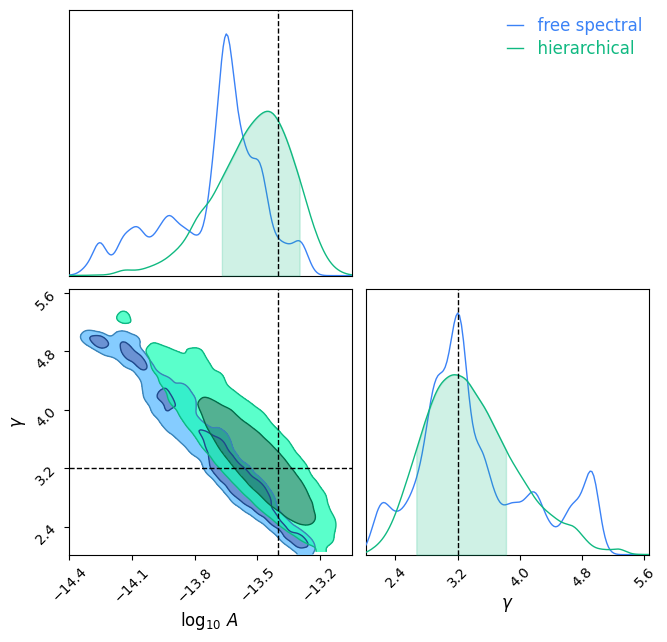

In [26]:
# compare power law hyper-model recovery
hyper_labels = [r'$\log_{{{10}}}\,A$', r'$\gamma$']
hypers_df = pd.DataFrame(hyper_samples, columns=hyper_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=hypers_df, name='free spectral'))
power_law_df = pd.DataFrame(power_samples.samples[:, power_pta.gwb_ndxs], columns=hyper_labels)
c.add_chain(Chain(samples=power_law_df, name='hierarchical'))
c.add_truth(Truth(location={name: val for name, val in zip(hyper_labels, pta.gwb_power_law_inj)}))
fig = c.plotter.plot()